## Fraud Detection in Financial Transactions

**Project Goal:**

The main goal of this project is to make a machine learning model, which is capable of accurately detecting possible fraudulent transactions in financial services. Based on customer behavior and payment actions, our team work to reduce potential financial losses and offering consistent service for users who are genuine. 


**Project Objectives**
- Detect fraudulent transactions using machine learning
- Handle class imbalance responsibly
- Compare classification models
- Tune probability thresholds for maximum recall
- Identify and select important features driving fraud
- Provide actionable business recommendations

## 1. Import Libraries

In [102]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report)

# Optional: imbalance handling (if needed)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpretability for XGBoost or Random Forest
import shap

# Utilities
import warnings
warnings.filterwarnings("ignore")

## 2. Load Dataset
- Check shape
- Check dtypes
- Check missing values

In [103]:
# Load Dataset
fraud_df = pd.read_csv('Fraud Detection Dataset.csv')
# Display first five rows
fraud_df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [104]:
# Check dataset shape
print("Shape of dataset (rows, columns):")
print(fraud_df.shape)

# Create a short data dictionary with data type and missing values
data_dictionary = pd.DataFrame({
    'Column Name': fraud_df.columns,
    'Data Type': fraud_df.dtypes.values,
    'Missing Values': fraud_df.isna().sum().values})

print("\nData Dictionary:")
data_dictionary

Shape of dataset (rows, columns):
(51000, 12)

Data Dictionary:


,Column Name,Data Type,Missing Values
0,Transaction_ID,object,0
1,User_ID,int64,0
2,Transaction_Amount,float64,2520
3,Transaction_Type,object,0
4,Time_of_Transaction,float64,2552
5,Device_Used,object,2473
6,Location,object,2547
7,Previous_Fraudulent_Transactions,int64,0
8,Account_Age,int64,0
9,Number_of_Transactions_Last_24H,int64,0


## 3. Exploratory Data Analysis (EDA)

We will focus on Transactions Trends, Device and Location Impact, User Behavior Analysis, and Payment Method Insights. 

### 3.1 Basic Exploration
- Summary statistics

In [105]:
# Summary statistics
print("Summary Statistics:")
fraud_df.describe().T

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
User_ID,51000.0,3005.110176,1153.121107,1000.00,2007.0000,2996.0,4006.00,4999.0
Transaction_Amount,48480.0,2996.249784,5043.932555,5.03,1270.5525,2524.1,3787.24,49997.8
Time_of_Transaction,48448.0,11.488400,6.922954,0.00,5.0000,12.0,17.00,23.0
Previous_Fraudulent_Transactions,51000.0,1.995725,1.415150,0.00,1.0000,2.0,3.00,4.0
Account_Age,51000.0,60.033902,34.384131,1.00,30.0000,60.0,90.00,119.0
Number_of_Transactions_Last_24H,51000.0,7.495588,4.020080,1.00,4.0000,7.0,11.00,14.0
Fraudulent,51000.0,0.049216,0.216320,0.00,0.0000,0.0,0.00,1.0


**Analysis:** The data shows majorly small to mid-sized transactions and user normally making 4-11 transactions in the last 24 hours, with average account age of 60 days.

### 3.2 Fix Data Types
- Convert strings to numeric using errors='coerce'
- Convert timestamps using pd.to_numeric()
- Convert categories using .astype('category')

In [106]:
# IDs as strings
fraud_df['Transaction_ID'] = fraud_df['Transaction_ID'].astype(str)
fraud_df['User_ID'] = fraud_df['User_ID'].astype(str)

# categorical features
fraud_df['Transaction_Type'] = fraud_df['Transaction_Type'].astype('category')
fraud_df['Device_Used'] = fraud_df['Device_Used'].astype('category')
fraud_df['Location'] = fraud_df['Location'].astype('category')
fraud_df['Payment_Method'] = fraud_df['Payment_Method'].astype('category')
fraud_df['Fraudulent'] = fraud_df['Fraudulent'].astype('category')
fraud_df['Time_of_Transaction'] = pd.to_numeric(fraud_df["Time_of_Transaction"], errors="coerce")

print(fraud_df.dtypes)
print("="*44)
print("Uniqueness of Variables:")
fraud_df.nunique()

Transaction_ID                        object
User_ID                               object
Transaction_Amount                   float64
Transaction_Type                    category
Time_of_Transaction                  float64
Device_Used                         category
Location                            category
Previous_Fraudulent_Transactions       int64
Account_Age                            int64
Number_of_Transactions_Last_24H        int64
Payment_Method                      category
Fraudulent                          category
dtype: object
Uniqueness of Variables:


Transaction_ID                      50000
User_ID                              4000
Transaction_Amount                  44821
Transaction_Type                        5
Time_of_Transaction                    24
Device_Used                             4
Location                                8
Previous_Fraudulent_Transactions        5
Account_Age                           119
Number_of_Transactions_Last_24H        14
Payment_Method                          5
Fraudulent                              2
dtype: int64

**Analysis:** Fixing data types ensures the data is appropriately structured for modeling, diminishes memory usage, and prevents wrong mathematical operations on non-numeric features, eventually enhancing the reliability of analysis later. The uniqueness shows varibales, especially categorical, have reasonable and distinct values.

Interesting Info: There are only 50,000 unique Transaction_ID from 51,000 rows, which means 1,000 IDs might be duplicates.

Non-Fraudulent Transactions: 48490
Fraudulent Transactions: 2510

Fraud Percentage: 4.92%


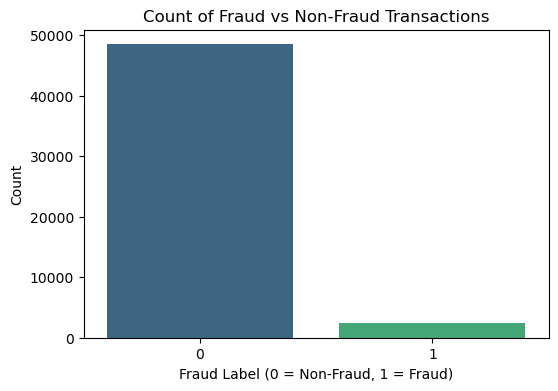

In [107]:
# Countplot for fraud vs non-fraud transactions
counts = fraud_df['Fraudulent'].value_counts()
fraud_percentage = (counts[1] / counts.sum()) * 100

print(f"Non-Fraudulent Transactions: {counts[0]}")
print(f"Fraudulent Transactions: {counts[1]}")
print(f"\nFraud Percentage: {fraud_percentage:.2f}%")

# Plot countplot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=fraud_df, x='Fraudulent', palette='viridis')

plt.title("Count of Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud Label (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

**Analysis:** This shows that dataset is highly imbalanced, with fraudulent transactions are only about 5% of total records. This indicates the need for handling class-imbalance technique like SMOTE during model training.

### 3.3 Outlier and Missing Values

Statistical info of Transaction Amount:
 count    48480.000000
mean      2996.249784
std       5043.932555
min          5.030000
25%       1270.552500
50%       2524.100000
75%       3787.240000
max      49997.800000
Name: Transaction_Amount, dtype: float64


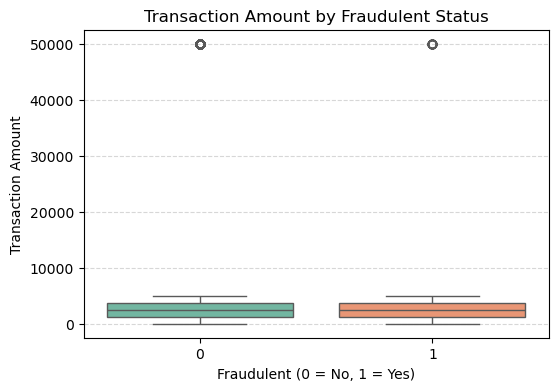

In [108]:
# Handling outliers in the transaction dataset using IQR
print('Statistical info of Transaction Amount:\n', fraud_df["Transaction_Amount"].describe())

# Boxplot: Amount by Fraud class
plt.figure(figsize=(6, 4))
sns.boxplot(x="Fraudulent", y="Transaction_Amount", data=fraud_df, palette="Set2")
plt.title("Transaction Amount by Fraudulent Status")
plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
plt.ylabel("Transaction Amount")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

**Analysis:** Both fraudulent and non-fraudulent transactions demonstrate very similar distribution of amounts with overlapping ranges, with few extreme values as outliers. This shows that transaction amount soley is not a good differenting feature for fraud.

**Distribution of Transaction_Amount for the fraudulent class only**

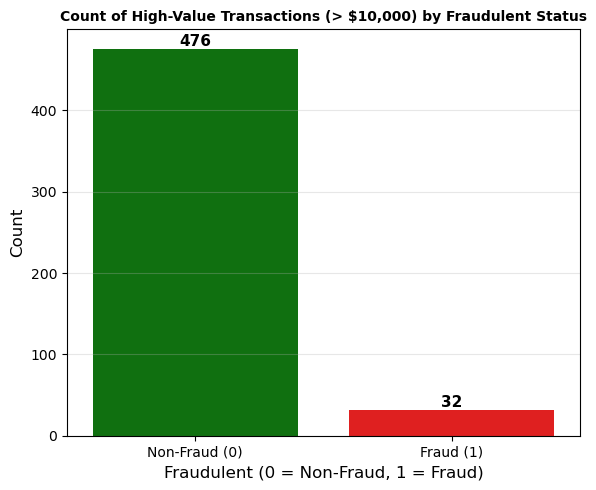


High-Value Transactions (> $49,000) Summary:
Total: 508
Non-Fraudulent: 476
Fraudulent: 32
Fraud Rate: 6.30%


In [109]:
# Filter transactions with amount > 10000
high_value_df = fraud_df[fraud_df['Transaction_Amount'] > 10000]

# Create countplot
plt.figure(figsize=(6, 5))
sns.countplot(data=high_value_df, x='Fraudulent', palette=['green', 'red'])
plt.title('Count of High-Value Transactions (> $10,000) by Fraudulent Status', fontsize=10, fontweight='bold')
plt.xlabel('Fraudulent (0 = Non-Fraud, 1 = Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])

# Add count labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fontsize=11, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Display summary
print(f"\nHigh-Value Transactions (> $49,000) Summary:")
print(f"Total: {len(high_value_df)}")
print(f"Non-Fraudulent: {len(high_value_df[high_value_df['Fraudulent'] == 0])}")
print(f"Fraudulent: {len(high_value_df[high_value_df['Fraudulent'] == 1])}")
print(f"Fraud Rate: {(len(high_value_df[high_value_df['Fraudulent'] == 1]) / len(high_value_df) * 100):.2f}%")

**Analysis:** The fraud rate within high-value transactions group goes up to about 6%, showing that fraudulent transactions are rare, yet they still pose considerably increased high fraud risk.

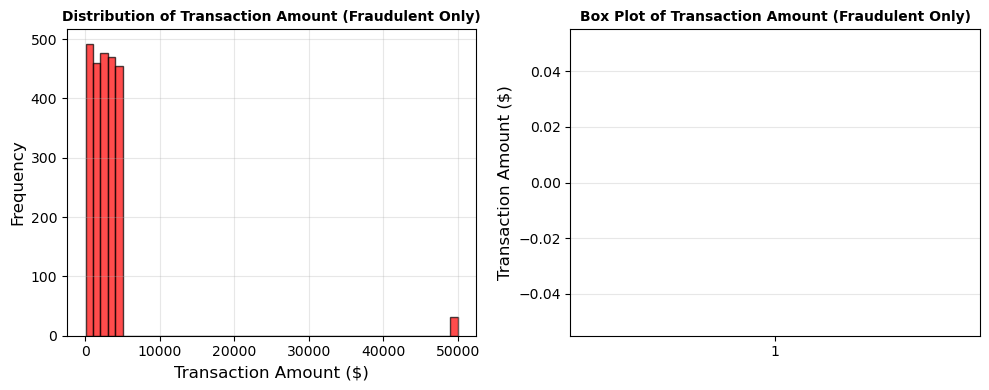


Summary Statistics for Fraudulent Transactions:
Total fraudulent transactions: 2510

Transaction Amount Statistics:
count     2385.000000
mean      3118.367245
std       5654.749402
min         14.310000
25%       1222.260000
50%       2516.010000
75%       3738.620000
max      49997.800000
Name: Transaction_Amount, dtype: float64

Median: $2516.01


In [110]:
# Filter for fraudulent transactions only
fraudulent_transactions = fraud_df[fraud_df['Fraudulent'] == 1]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
axes[0].hist(fraudulent_transactions['Transaction_Amount'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Transaction Amount (Fraudulent Only)', fontsize=10, fontweight='bold')
axes[0].set_xlabel('Transaction Amount ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(fraudulent_transactions['Transaction_Amount'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='red', alpha=0.7),
                medianprops=dict(color='darkred', linewidth=2),
                whiskerprops=dict(color='red'),
                capprops=dict(color='red'))
axes[1].set_title('Box Plot of Transaction Amount (Fraudulent Only)', fontsize=10, fontweight='bold')
axes[1].set_ylabel('Transaction Amount ($)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics for Fraudulent Transactions:")
print(f"Total fraudulent transactions: {len(fraudulent_transactions)}")
print(f"\nTransaction Amount Statistics:")
print(fraudulent_transactions['Transaction_Amount'].describe())
print(f"\nMedian: ${fraudulent_transactions['Transaction_Amount'].median():.2f}")

From these above three plots (countplot, histogram, and boxplot), it can be seen that fraudulent transactions exhibit a right-skewed distribution with most fraudulent transactions clustered between `$1,000` – `$5,000`, showing that frauds generally go with moderate amounts that appear normal. Out of total 508 outliers in transaction amount, only 32 transactions are fraudulent. These high-value transactions show occasional fraud attempts but do not depict typical fraud behavior. Also, some transactions with extreme values are fraudulent, so we can not simply remove the outliers as they contain important information about fraudulent cases. 

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64


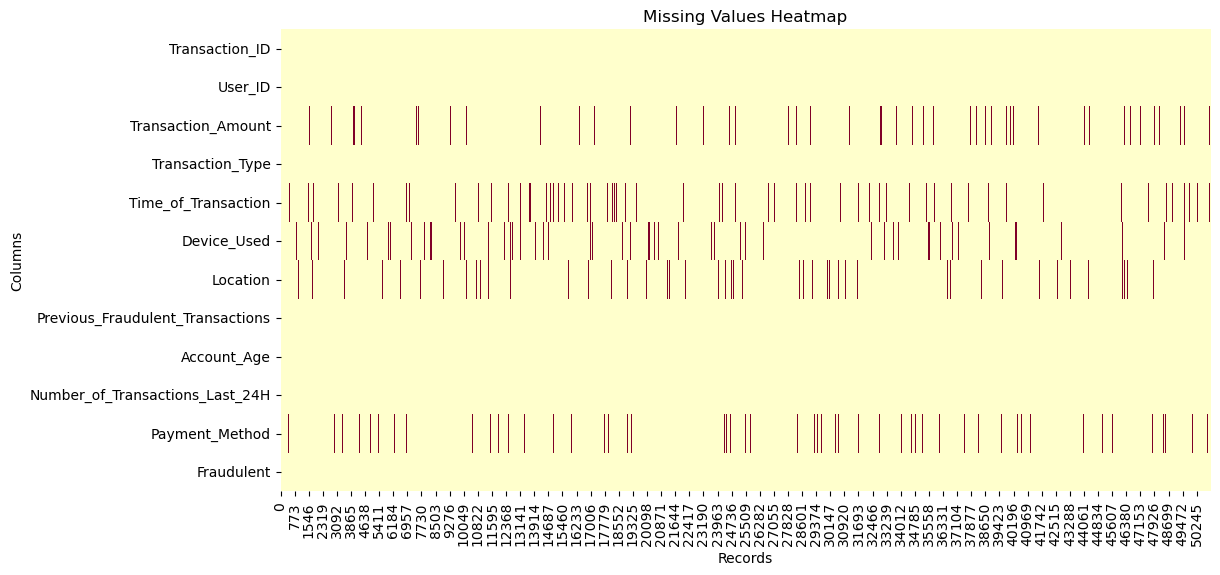

In [111]:
# Visualize the missing values as a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(fraud_df.isnull().T, cbar=False, cmap='YlOrRd')
plt.title('Missing Values Heatmap')

plt.xlabel('Records')
plt.ylabel('Columns')
print(fraud_df.isnull().sum())
plt.show()

**Analysis:** This heatmap indicates that only a few features need imputation as missing values are concentrated in `Transaction_Amount`, `Time_of_Transaction`, `Device_Used`, `Location`, and `Payment_Method`, while other varibles remain complete.

### 3.4 Transactions Trends

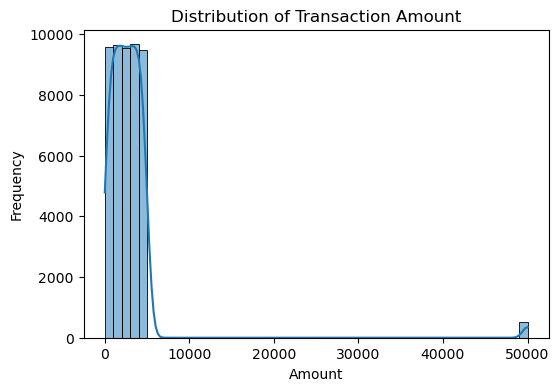

In [112]:
# Distribution of transaction amount
# Histogram / KDE plot: Transaction amount
plt.figure(figsize=(6,4))
sns.histplot(fraud_df['Transaction_Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

**Analysis:** This plot depicts that distribution is extremely right-skewed due to few outliers around `$50,000`.

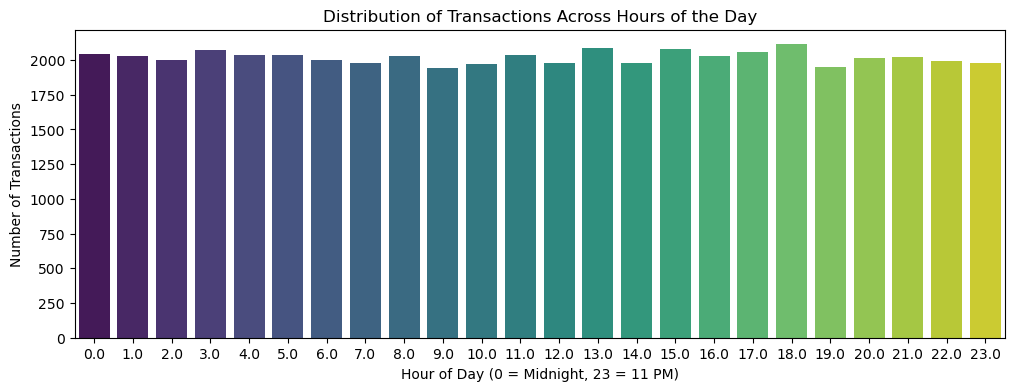

In [113]:
# Number of Transactions by Time of Day (Bar Chart)
fraud_df['Time_of_Transaction'] = fraud_df['Time_of_Transaction']

plt.figure(figsize=(12,4))
sns.countplot(data=fraud_df, x='Time_of_Transaction', palette='viridis')

plt.title("Distribution of Transactions Across Hours of the Day")
plt.xlabel("Hour of Day (0 = Midnight, 23 = 11 PM)")
plt.ylabel("Number of Transactions")
plt.xticks(range(0,24))
plt.show()

**Analysis:** All transactions have steady pattern throughout the day with only tiny fluctuations, showing no solid hourly trend in overall.

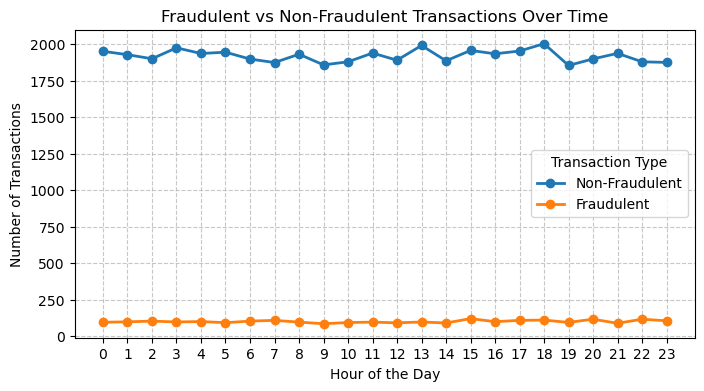

In [114]:
# Fraudulent vs Non-Fraudulent Transactions Over Time (Time Series)
# Group by hour and fraud label
fraud_trend = fraud_df.groupby(["Time_of_Transaction", "Fraudulent"]).size().unstack()

# Plot
plt.figure(figsize=(8,4))
plt.plot(fraud_trend.index, fraud_trend[0], marker='o', linewidth=2, label="Non-Fraudulent")
plt.plot(fraud_trend.index, fraud_trend[1], marker='o', linewidth=2, label="Fraudulent")

plt.title("Fraudulent vs Non-Fraudulent Transactions Over Time", fontsize=12)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.legend(title="Transaction Type")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.show()

**Analysis:** Both fraud and non-fraud transactions follow a very similar hourly pattern throughout the day, showing no robust relationship between time-of-day and fraud.

### 3.5 User Behavior Analysis 

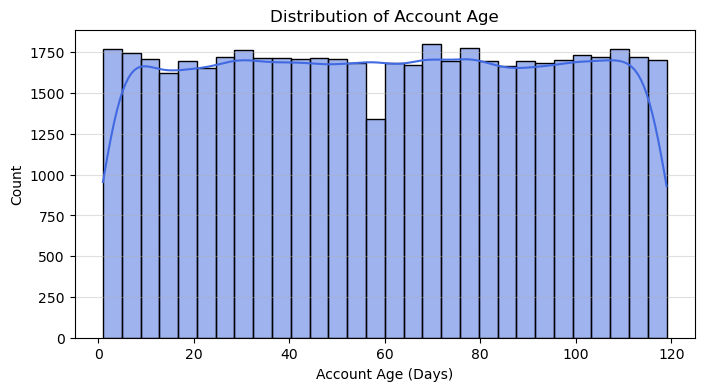

Correlation (Account Age vs Previous Fraudulent Transactions): 0.0009564166923260228


In [115]:
# User Behavior Analysis
# Distribution of Account Age
plt.figure(figsize=(8, 4))
sns.histplot(fraud_df["Account_Age"], bins=30, kde=True, color="royalblue")
plt.title("Distribution of Account Age")
plt.xlabel("Account Age (Days)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.4)
plt.show()

# Correlation between Account Age and Previous Fraudulent Transactions
corr_val = fraud_df["Previous_Fraudulent_Transactions"].corr(fraud_df["Account_Age"])
print("Correlation (Account Age vs Previous Fraudulent Transactions):", corr_val)

**Analysis:** Account age is evenly distributed and there is no correlation with past fraud bahevior. This suggests `Account_Age` is not very influential feature in fraud risk in this data.

In [116]:
# Check number of unique values in each column
display(fraud_df.nunique().T)

Transaction_ID                      50000
User_ID                              4000
Transaction_Amount                  44821
Transaction_Type                        5
Time_of_Transaction                    24
Device_Used                             4
Location                                8
Previous_Fraudulent_Transactions        5
Account_Age                           119
Number_of_Transactions_Last_24H        14
Payment_Method                          5
Fraudulent                              2
dtype: int64

**Analysis:** Majority of transactions in last 24 hours occur only in certain different 14 hours.

**Assessing number of transactions in last 24 hours**

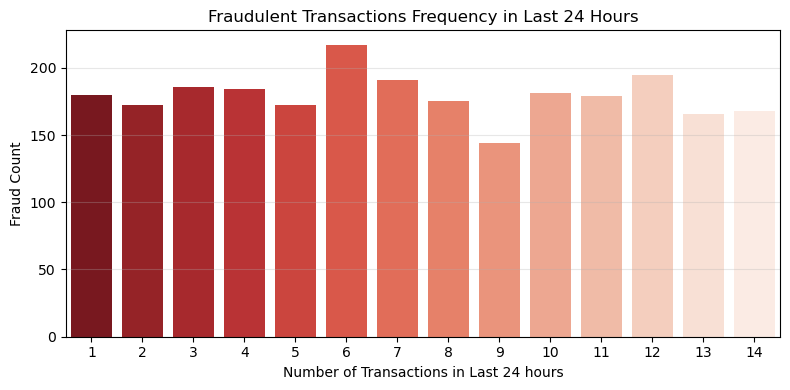

In [117]:
# Fraud Count by Number of Transactions in Last 24 Hours
fraud_by_hour = fraud_df[fraud_df['Fraudulent'] == 1].groupby('Number_of_Transactions_Last_24H').size()
plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette="Reds_r")
plt.title("Fraudulent Transactions Frequency in Last 24 Hours")
plt.xlabel("Number of Transactions in Last 24 hours")
plt.ylabel("Fraud Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

**Analysis:** In last 24 hours, even though trend shows that fraud counts remains somewhat steady, at 6 transactions the fraud count rises to more than 200, which might be a good indicator of potential fraud because customers or user who perform more frequent transactions are likely to show higher fraud cases. Additionally, `Number_of_Transactions_Last_24H` is our velocity feature for this project.

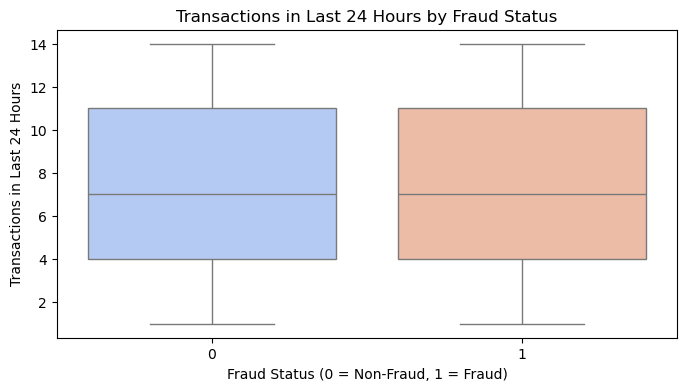

In [118]:
# Boxplot for Fraud vs Non-Fraud Comparison
plt.figure(figsize=(8,4))
sns.boxplot(data=fraud_df, x="Fraudulent", y="Number_of_Transactions_Last_24H", palette="coolwarm")
plt.title("Transactions in Last 24 Hours by Fraud Status")
plt.xlabel("Fraud Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transactions in Last 24 Hours")
plt.show()

**Analysis:** Both class have same distribution of transactions in last 24 hours, indicating this feature alone is not sufficient for fraud detection.

### 3.6 Payment Method Insights 

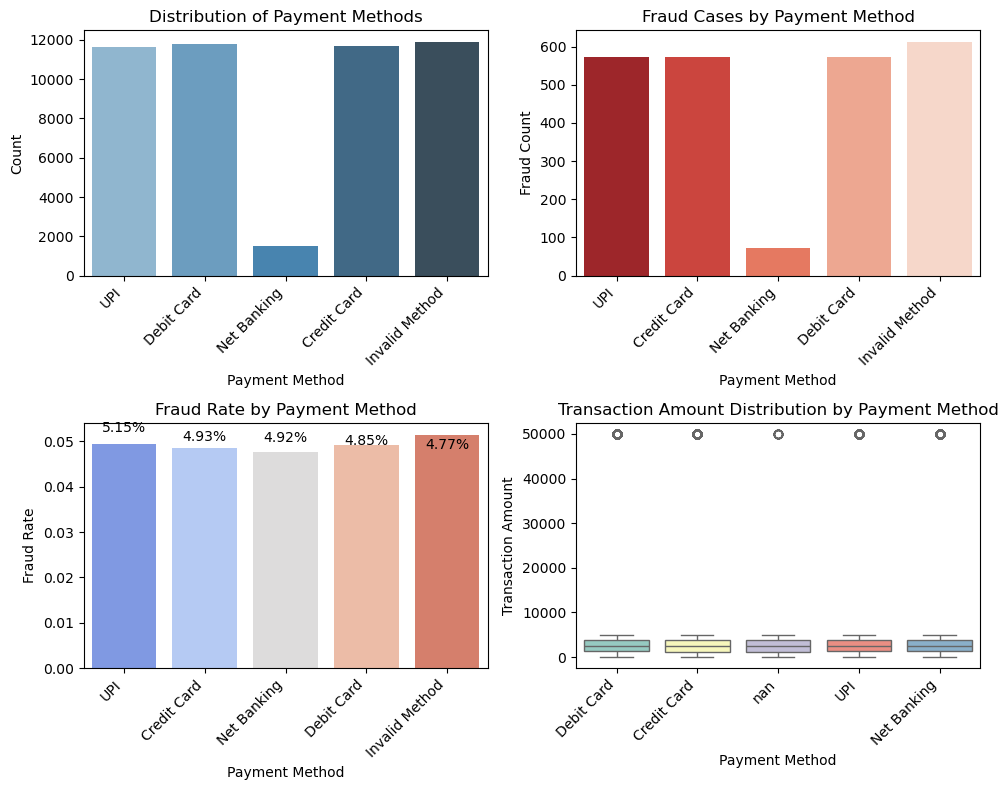

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Distribution of Payment Methods
pm_counts = fraud_df["Payment_Method"].value_counts()
sns.barplot(x=pm_counts.index, y=pm_counts.values, palette="Blues_d", ax=axes[0])
axes[0].set_title("Distribution of Payment Methods")
axes[0].set_xlabel("Payment Method")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(pm_counts.index, rotation=45, ha="right")

# Fraud count by Payment Method
fraud_pm = fraud_df.loc[fraud_df["Fraudulent"] == 1, "Payment_Method"].value_counts()
sns.barplot(x=fraud_pm.index, y=fraud_pm.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("Fraud Cases by Payment Method")
axes[1].set_xlabel("Payment Method")
axes[1].set_ylabel("Fraud Count")
axes[1].set_xticklabels(fraud_pm.index, rotation=45, ha="right")

# Fraud Rate by Payment Method
pm_table = pd.crosstab(fraud_df["Payment_Method"], fraud_df["Fraudulent"])
pm_table["Fraud Rate"] = pm_table[1] / pm_table.sum(axis=1)
pm_table = pm_table.sort_values("Fraud Rate", ascending=False)

sns.barplot(x=pm_table.index, y=pm_table["Fraud Rate"], palette="coolwarm", ax=axes[2])
axes[2].set_title("Fraud Rate by Payment Method")
axes[2].set_xlabel("Payment Method")
axes[2].set_ylabel("Fraud Rate")
axes[2].set_xticklabels(pm_table.index, rotation=45, ha="right")

# Add percentage labels
for i, rate in enumerate(pm_table["Fraud Rate"]):
    axes[2].text(i, rate, f"{rate:.2%}", ha="center", va="bottom", fontsize=10)

# Boxplot: Amount vs Payment Method
sns.boxplot(data=fraud_df, x="Payment_Method", y="Transaction_Amount", palette="Set3", ax=axes[3])
axes[3].set_title("Transaction Amount Distribution by Payment Method")
axes[3].set_xlabel("Payment Method")
axes[3].set_ylabel("Transaction Amount")
axes[3].set_xticklabels(fraud_df["Payment_Method"].unique(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

**Analysis:** Fraud counts are almost similar for all payment methods except for `Net Banking` (lowest volume), however transaction amount trend looks same as other methods, even though fraud rates are same at around 5%. This highlights that fraud is not soley associated with payment methods as well.

### 3.7 Device and Location Impact

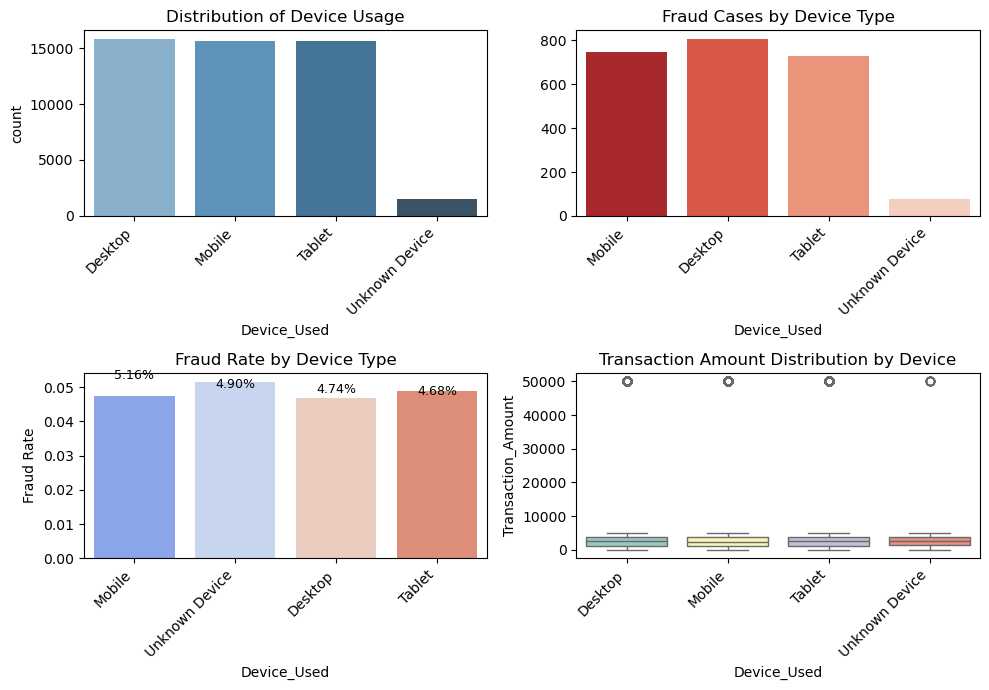

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()

# Precompute fraud stats
fraud_by_device = fraud_df.loc[fraud_df["Fraudulent"] == 1, "Device_Used"].value_counts()
stats = pd.crosstab(fraud_df["Device_Used"], fraud_df["Fraudulent"])
stats["Fraud Rate"] = stats[1] / stats.sum(axis=1)
stats = stats.sort_values("Fraud Rate", ascending=False)

# 1. Distribution of Devices
sns.countplot(data=fraud_df, x="Device_Used", palette="Blues_d", ax=axes[0])
axes[0].set_title("Distribution of Device Usage")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# 2. Fraud Count by Device
sns.barplot(x=fraud_by_device.index, y=fraud_by_device.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("Fraud Cases by Device Type")
axes[1].set_xticklabels(fraud_by_device.index, rotation=45, ha="right")

# 3. Fraud Rate by Device
sns.barplot(x=stats.index, y=stats["Fraud Rate"], palette="coolwarm", ax=axes[2])
axes[2].set_title("Fraud Rate by Device Type")
axes[2].set_xticklabels(stats.index, rotation=45, ha="right")
for i, rate in enumerate(stats["Fraud Rate"]):
    axes[2].text(i, rate, f"{rate:.2%}", ha="center", va="bottom", fontsize=9)

# 4. Amount Distribution by Device
sns.boxplot(data=fraud_df, x="Device_Used", y="Transaction_Amount", palette="Set3", ax=axes[3])
axes[3].set_title("Transaction Amount Distribution by Device")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

**Analysis:** Mobile, Desktop, and Tablet are associated with higher fraud cases as these devices are utilized frequently, however fraud rate looks consistent across all devices at around 5%. And distribution of transaction amount also appears similar across devices, suggesting device preference does not mainly affects the fraudulent size.

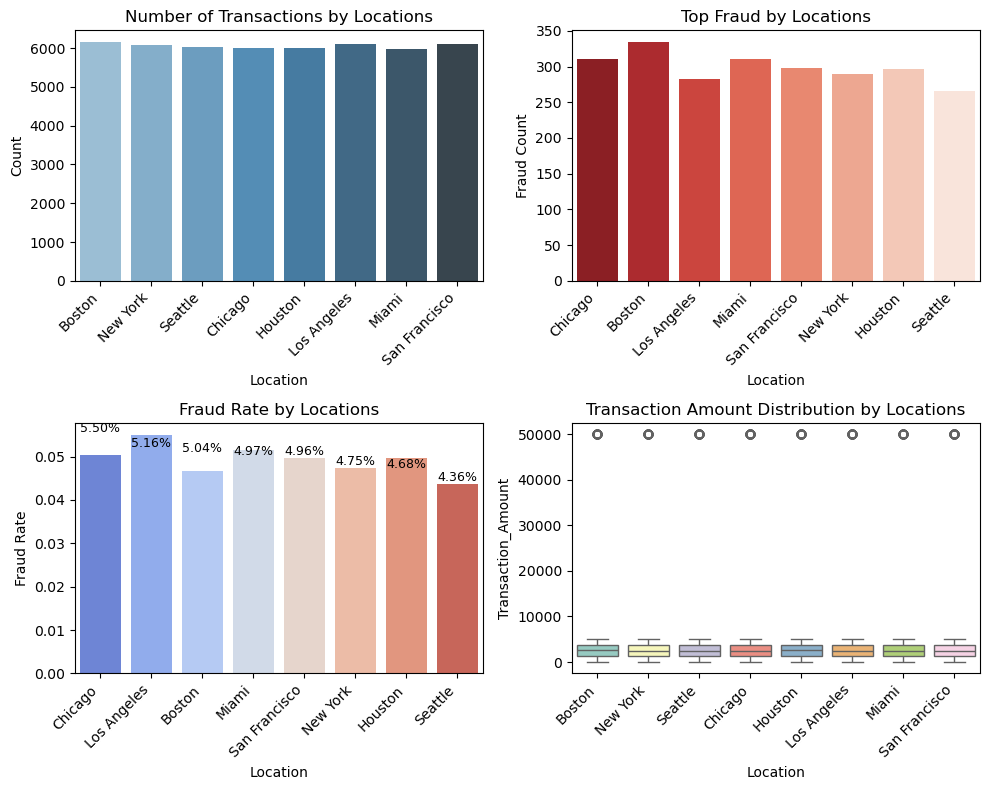

In [121]:
# Compute summary tables
loc_counts = fraud_df["Location"].value_counts()
fraud_loc = fraud_df.loc[fraud_df["Fraudulent"] == 1, "Location"].value_counts()

loc_table = pd.crosstab(fraud_df["Location"], fraud_df["Fraudulent"])
loc_table["Fraud Rate"] = loc_table[1] / loc_table.sum(axis=1)
loc_table = loc_table.sort_values("Fraud Rate", ascending=False)

top10 = loc_counts.index

# Create 2x2 subplot grid (no extra plots)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Top locations by transaction count
sns.barplot(x=loc_counts.index, y=loc_counts.values, palette="Blues_d", ax=axes[0])
axes[0].set_title("Number of Transactions by Locations")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(loc_counts.index, rotation=45, ha="right")

# Locations with most fraud cases
sns.barplot(x=fraud_loc.index, y=fraud_loc.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("Top Fraud by Locations")
axes[1].set_ylabel("Fraud Count")
axes[1].set_xticklabels(fraud_loc.index, rotation=45, ha="right")

# Fraud Rate by Location
sns.barplot(x=loc_table.index, y=loc_table["Fraud Rate"], palette="coolwarm", ax=axes[2])
axes[2].set_title("Fraud Rate by Locations")
axes[2].set_ylabel("Fraud Rate")
axes[2].set_xticklabels(loc_table.index, rotation=45, ha="right")

# Add percentage labels
for i, rate in enumerate(loc_table["Fraud Rate"]):
    axes[2].text(i, rate, f"{rate:.2%}", ha="center", va="bottom", fontsize=9)

# Boxplot for Amount vs Location
sns.boxplot(
    data=fraud_df[fraud_df["Location"].isin(top10)],
    x="Location",
    y="Transaction_Amount",
    palette="Set3",
    ax=axes[3])
axes[3].set_title("Transaction Amount Distribution by Locations")
axes[3].set_xticklabels(top10, rotation=45, ha="right")

plt.tight_layout()
plt.show()

**Analysis:** Los Angeles, San Francisco, and Chicago show the highest number of frauds as well as fraud rates. But if we see transaction amounts are fairly consistent across the cities. Therefore, may be behavioral or regional factors drive the higher fraud activity in certain cities.

### 3.8 Correlation Analysis

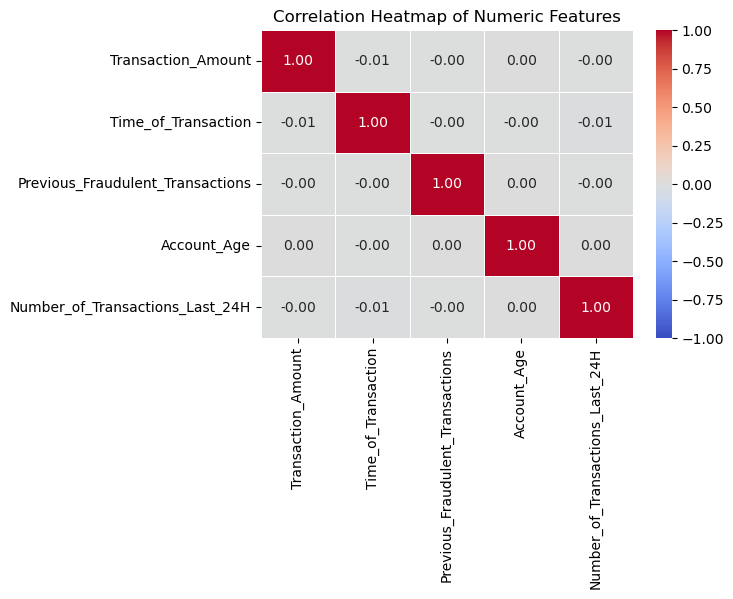

In [122]:
# Heatmap of Correlation Analysis
numeric_cols = fraud_df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = fraud_df[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Analysis:** All the numeric features illustrate almost no correlation with each other, indicating that each feature might contribute separate information to the detection model.

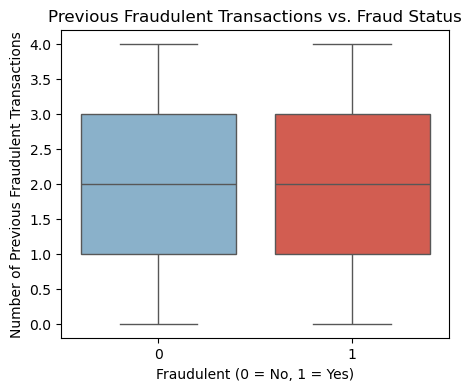

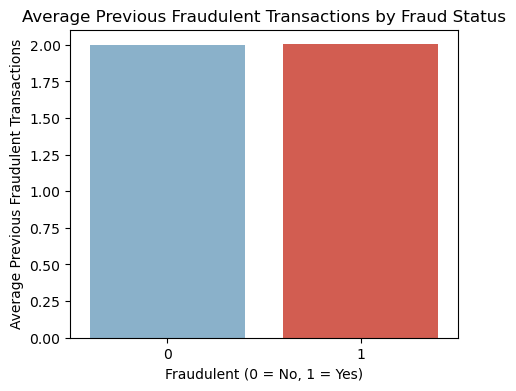

In [123]:
# Relationship Between Previous Fraudulent Transactions and Fraud Outcome
plt.figure(figsize=(5, 4))
sns.boxplot(
    data=fraud_df,
    x="Fraudulent",
    y="Previous_Fraudulent_Transactions",
    palette=["#7FB3D5", "#E74C3C"])
plt.title("Previous Fraudulent Transactions vs. Fraud Status")
plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
plt.ylabel("Number of Previous Fraudulent Transactions")
plt.show()

# Bar chart for clearer separation
plt.figure(figsize=(5, 4))
sns.barplot(
    x=fraud_df["Fraudulent"],
    y=fraud_df["Previous_Fraudulent_Transactions"],
    palette=["#7FB3D5", "#E74C3C"],
    ci=None)
plt.title("Average Previous Fraudulent Transactions by Fraud Status")
plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
plt.ylabel("Average Previous Fraudulent Transactions")
plt.show()

From the boxplot and barplot, we can see that average number of previous fraudulent trasnactions for both fraudulent class is 2. Overall, historical fraud count does not vividly distinguish fraudulent vs non-fraudulent users. This is why `Previous_Fraudulent_Transactions` indicated zero linear correlation with other predictors in the heatmap, whereas I think fraud behavior is usually non-linear. We hope to address this issue with applying Random Forest and XGBoost models, which are highly predictive in non-linear relationships.

## 4. Data Cleaning and Preprocessing

### 4.1 Handle Missing Values
- Transaction_Amount: The distribution of amounts is often highly skewed. Median is robust and prevents extreme distortion.
- Time_of_Transaction: Impute with mode (most common hour) because time of day is discrete (0–23), median is less meaningful.
- Device_Used, Location, and Payment_Method: Replace missing with "Unknown". "Unknown" preserves the information that something is suspicious about the record. Fraud models often learn that “Unknown” location is more risky.

In [124]:
# Numerical imputations
fraud_df['Transaction_Amount'] = fraud_df['Transaction_Amount'].fillna(fraud_df['Transaction_Amount'].median())
fraud_df['Time_of_Transaction'] = fraud_df['Time_of_Transaction'].fillna(fraud_df['Time_of_Transaction'].mode()[0])

# Categorical imputations
for col in ["Device_Used", "Location", "Payment_Method"]:
    fraud_df[col] = fraud_df[col].astype("object").fillna("Unknown")
    fraud_df[col] = fraud_df[col].astype("category")

fraud_df.isnull().sum()

Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64

**Analysis:** Dropping rows with missing values can introduce bias and reduce sample size in fraud datasets. Therefore, we have imputed the missing values.

### 4.2 Handle Duplicates

In [125]:
# Check for exact duplicates
fraud_df[fraud_df.duplicated()]

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
50000,T33554,2669,2425.71,Bank Transfer,14.0,Tablet,Seattle,2,40,7,UPI,0
50001,T9428,1001,2448.53,Bank Transfer,19.0,Mobile,San Francisco,4,7,3,Unknown,0
50002,T200,3790,4429.89,ATM Withdrawal,17.0,Unknown,Miami,1,39,6,UPI,1
50003,T12448,1743,108.00,ATM Withdrawal,15.0,Tablet,Los Angeles,3,67,9,Credit Card,0
50004,T39490,4329,2320.30,ATM Withdrawal,4.0,Desktop,Los Angeles,3,12,10,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50993,T5873,4911,3613.59,Online Purchase,11.0,Tablet,New York,3,58,7,Net Banking,0
50994,T48244,4842,1587.84,POS Payment,10.0,Tablet,New York,1,94,6,UPI,0
50995,T33982,2339,3112.51,Bill Payment,15.0,Mobile,New York,0,7,8,Debit Card,0
50996,T31261,2152,2897.15,Online Purchase,3.0,Mobile,Miami,1,75,11,Net Banking,1


This shows dataset has 881 duplicate records.

In [126]:
# Check for duplicate Transaction_ID
fraud_df.duplicated(subset=['Transaction_ID']).sum()

np.int64(1000)

In [127]:
# Drop only exact duplicates
fraud_df = fraud_df.drop_duplicates()

# Drop Transaction_ID duplicates
fraud_df = fraud_df.drop_duplicates(subset=['Transaction_ID'])
fraud_df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,18.0,Mobile,Unknown,3,115,9,Unknown,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,T49996,1296,1844.08,Online Purchase,22.0,Desktop,Los Angeles,1,47,4,Credit Card,0
49996,T49997,3592,3274.95,POS Payment,15.0,Mobile,San Francisco,2,81,1,UPI,0
49997,T49998,3536,647.11,Bill Payment,11.0,Unknown Device,Miami,2,96,3,Debit Card,0
49998,T49999,2019,2446.65,POS Payment,9.0,Tablet,Boston,3,117,13,UPI,0


In [128]:
# Check remaining duplicates after dropping them
remaining_duplicates = fraud_df.duplicated().sum()
print("Remaining duplicates:", remaining_duplicates)
fraud_df.shape

Remaining duplicates: 0


(50000, 12)

**Analysis:** As part of handling duplicates, 1000 duplicates have been dropped to avoid biased model training and inflated counts of transactions. After eliminating duplicates, the dataframe was for checked again and it showed no remaining duplicates.

### 4.3 Encode Categorical Features

In [129]:
# Creating a list of categorical features to convert into numeric format
categorical_features = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']

# One-hot encode categorical features and 'drop_first = True' avoids multicollinearity in the data
fraud_df_encoded = pd.get_dummies(fraud_df, columns=categorical_features, drop_first=True)
fraud_df_encoded

,Transaction_ID,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent,Transaction_Type_Bank Transfer,Transaction_Type_Bill Payment,...,Location_Miami,Location_New York,Location_San Francisco,Location_Seattle,Location_Unknown,Payment_Method_Debit Card,Payment_Method_Invalid Method,Payment_Method_Net Banking,Payment_Method_UPI,Payment_Method_Unknown
0,T1,4174,1292.76,16.0,0,119,13,0,False,False,...,False,False,True,False,False,True,False,False,False,False
1,T2,4507,1554.58,13.0,4,79,3,0,False,False,...,False,True,False,False,False,False,False,False,False,False
2,T3,1860,2395.02,18.0,3,115,9,0,False,False,...,False,False,False,False,True,False,False,False,False,True
3,T4,2294,100.10,15.0,4,3,4,0,False,True,...,False,False,False,False,False,False,False,False,True,False
4,T5,2130,1490.50,19.0,2,57,7,0,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,T49996,1296,1844.08,22.0,1,47,4,0,False,False,...,False,False,False,False,False,False,False,False,False,False
49996,T49997,3592,3274.95,15.0,2,81,1,0,False,False,...,False,False,True,False,False,False,False,False,True,False
49997,T49998,3536,647.11,11.0,2,96,3,0,False,True,...,True,False,False,False,False,True,False,False,False,False
49998,T49999,2019,2446.65,9.0,3,117,13,0,False,False,...,False,False,False,False,False,False,False,False,True,False


In [130]:
# Check data types of encoded variables
fraud_df_encoded.dtypes

Transaction_ID                        object
User_ID                               object
Transaction_Amount                   float64
Time_of_Transaction                  float64
Previous_Fraudulent_Transactions       int64
Account_Age                            int64
Number_of_Transactions_Last_24H        int64
Fraudulent                          category
Transaction_Type_Bank Transfer          bool
Transaction_Type_Bill Payment           bool
Transaction_Type_Online Purchase        bool
Transaction_Type_POS Payment            bool
Device_Used_Mobile                      bool
Device_Used_Tablet                      bool
Device_Used_Unknown                     bool
Device_Used_Unknown Device              bool
Location_Chicago                        bool
Location_Houston                        bool
Location_Los Angeles                    bool
Location_Miami                          bool
Location_New York                       bool
Location_San Francisco                  bool
Location_S

**Analysis:** All categorical varibles are transformed into numeric indicator columns for machine learning models, which need numeric inputs.

### 4.4 Feature Engineering
- Recency and Transaction Velocity

Since we already have `Number_of_Transactions_Last_24H` in our dataset, which will be our velocity feature. So, we will only deal with recency (`time since last transaction`) in this portion.

In [131]:
# Dsiplay all the features
fraud_df_encoded.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount',
       'Time_of_Transaction', 'Previous_Fraudulent_Transactions',
       'Account_Age', 'Number_of_Transactions_Last_24H', 'Fraudulent',
       'Transaction_Type_Bank Transfer', 'Transaction_Type_Bill Payment',
       'Transaction_Type_Online Purchase', 'Transaction_Type_POS Payment',
       'Device_Used_Mobile', 'Device_Used_Tablet', 'Device_Used_Unknown',
       'Device_Used_Unknown Device', 'Location_Chicago', 'Location_Houston',
       'Location_Los Angeles', 'Location_Miami', 'Location_New York',
       'Location_San Francisco', 'Location_Seattle', 'Location_Unknown',
       'Payment_Method_Debit Card', 'Payment_Method_Invalid Method',
       'Payment_Method_Net Banking', 'Payment_Method_UPI',
       'Payment_Method_Unknown'],
      dtype='object')

In [132]:
# Sort transactions by user and transaction hour
fraud_df = fraud_df.sort_values(["User_ID", "Time_of_Transaction"])
fraud_df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
4523,T4524,1000,1543.51,Bill Payment,3.0,Unknown,Miami,3,2,1,Net Banking,0
38443,T38444,1000,3140.55,Online Purchase,4.0,Desktop,Los Angeles,1,104,11,Invalid Method,0
15308,T15309,1000,4394.37,Bill Payment,10.0,Tablet,Chicago,0,61,8,Net Banking,0
22242,T22243,1000,982.92,Bill Payment,10.0,Mobile,Houston,2,98,8,Net Banking,0
29112,T29113,1000,1197.00,Bill Payment,10.0,Mobile,Seattle,2,40,2,UPI,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23536,T23537,4999,3927.54,POS Payment,12.0,Mobile,Unknown,1,103,4,UPI,1
33314,T33315,4999,1347.04,Bill Payment,19.0,Tablet,Boston,2,1,5,Debit Card,0
43020,T43021,4999,91.28,Bank Transfer,20.0,Mobile,Miami,0,35,13,Debit Card,0
7543,T7544,4999,2770.47,POS Payment,22.0,Mobile,San Francisco,3,87,1,Debit Card,0


In [133]:
# Create new recency feature to assess the hours since previous transaction for each customer
fraud_df["Hours_Since_Last_Transaction"] = (fraud_df.groupby("User_ID")["Time_of_Transaction"]
            .diff()           # difference in hours to previous transaction
            .fillna(24.0)     # first transaction per user is assumed as 24 hours gap
)
fraud_df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Hours_Since_Last_Transaction
4523,T4524,1000,1543.51,Bill Payment,3.0,Unknown,Miami,3,2,1,Net Banking,0,24.0
38443,T38444,1000,3140.55,Online Purchase,4.0,Desktop,Los Angeles,1,104,11,Invalid Method,0,1.0
15308,T15309,1000,4394.37,Bill Payment,10.0,Tablet,Chicago,0,61,8,Net Banking,0,6.0
22242,T22243,1000,982.92,Bill Payment,10.0,Mobile,Houston,2,98,8,Net Banking,0,0.0
29112,T29113,1000,1197.00,Bill Payment,10.0,Mobile,Seattle,2,40,2,UPI,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,T23537,4999,3927.54,POS Payment,12.0,Mobile,Unknown,1,103,4,UPI,1,0.0
33314,T33315,4999,1347.04,Bill Payment,19.0,Tablet,Boston,2,1,5,Debit Card,0,7.0
43020,T43021,4999,91.28,Bank Transfer,20.0,Mobile,Miami,0,35,13,Debit Card,0,1.0
7543,T7544,4999,2770.47,POS Payment,22.0,Mobile,San Francisco,3,87,1,Debit Card,0,2.0


In [134]:
# Add engineered recency feature into the encoded dataframe
fraud_df_encoded["Hours_Since_Last_Transaction"] = fraud_df["Hours_Since_Last_Transaction"]
fraud_df_encoded

,Transaction_ID,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent,Transaction_Type_Bank Transfer,Transaction_Type_Bill Payment,...,Location_New York,Location_San Francisco,Location_Seattle,Location_Unknown,Payment_Method_Debit Card,Payment_Method_Invalid Method,Payment_Method_Net Banking,Payment_Method_UPI,Payment_Method_Unknown,Hours_Since_Last_Transaction
0,T1,4174,1292.76,16.0,0,119,13,0,False,False,...,False,True,False,False,True,False,False,False,False,3.0
1,T2,4507,1554.58,13.0,4,79,3,0,False,False,...,True,False,False,False,False,False,False,False,False,6.0
2,T3,1860,2395.02,18.0,3,115,9,0,False,False,...,False,False,False,True,False,False,False,False,True,1.0
3,T4,2294,100.10,15.0,4,3,4,0,False,True,...,False,False,False,False,False,False,False,True,False,1.0
4,T5,2130,1490.50,19.0,2,57,7,0,False,False,...,False,True,False,False,False,False,False,False,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,T49996,1296,1844.08,22.0,1,47,4,0,False,False,...,False,False,False,False,False,False,False,False,False,3.0
49996,T49997,3592,3274.95,15.0,2,81,1,0,False,False,...,False,True,False,False,False,False,False,True,False,1.0
49997,T49998,3536,647.11,11.0,2,96,3,0,False,True,...,False,False,False,False,True,False,False,False,False,3.0
49998,T49999,2019,2446.65,9.0,3,117,13,0,False,False,...,False,False,False,False,False,False,False,True,False,0.0


**Analysis:** From feature engineering, based on EDA, we have created our recency feature from cleaned dataframe `fraud_df`, which is `Hours_Since_Last_Transaction` and is added to `fraud_df_encoded`. This created recency feature will also be included in the modeling process.

### 4.5 Feature Selection
After getting all the features needed for modeling, now we need to select majorly contributing features and remove weak or redundant or uninformative features.

Methods used:
- Zero-varinace
- Correlation
- Mutual Information

**Remove zero-variance**

In [135]:
# Import required libraries
from sklearn.feature_selection import VarianceThreshold

# Create the selector that removes only features whose variance = 0
vt = VarianceThreshold(threshold=0.0)
# Fit the selector on the feature set (excluding ID columns and target), computing the variance of each feature.
vt.fit(fraud_df_encoded.drop(columns=['Transaction_ID', 'User_ID', 'Fraudulent']))

# Get the names of columns that passed the variance check and returns a boolean mask for selected features
selected_cols = fraud_df_encoded.drop(columns=['Transaction_ID', 'User_ID', 'Fraudulent']).columns[vt.get_support()]
X_reduced = fraud_df_encoded[selected_cols]
X_reduced

,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Transaction_Type_Bank Transfer,Transaction_Type_Bill Payment,Transaction_Type_Online Purchase,Transaction_Type_POS Payment,Device_Used_Mobile,...,Location_New York,Location_San Francisco,Location_Seattle,Location_Unknown,Payment_Method_Debit Card,Payment_Method_Invalid Method,Payment_Method_Net Banking,Payment_Method_UPI,Payment_Method_Unknown,Hours_Since_Last_Transaction
0,1292.76,16.0,0,119,13,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,3.0
1,1554.58,13.0,4,79,3,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,6.0
2,2395.02,18.0,3,115,9,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,1.0
3,100.10,15.0,4,3,4,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,1.0
4,1490.50,19.0,2,57,7,False,False,False,True,True,...,False,True,False,False,False,False,False,False,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1844.08,22.0,1,47,4,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,3.0
49996,3274.95,15.0,2,81,1,False,False,False,True,True,...,False,True,False,False,False,False,False,True,False,1.0
49997,647.11,11.0,2,96,3,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,3.0
49998,2446.65,9.0,3,117,13,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,0.0


**Analysis:** No features were removed using `Zero-varinace` because after data cleaning, encoding, and feature preparation, none of the features had zero or near-zero varinace.

**Remove Highly Correlated Features**

In [136]:
# Remove highly correlated features (correlation > 0.75)
corr_matrix = X_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print("Highly correlated features removed:", len(to_drop))

X_reduced = X_reduced.drop(columns=to_drop)

Highly correlated features removed: 0


**Analysis:** No features are correlated to each other as shown in `correlation analysis`.

**Mutual Information (MI)**

MI is useful for feature selection for project with mixed data types and it tells us how much information each feature gives about the target. In this code block `X_reduced` is technically `fraud_df_encoded` as no features were removed earlier.

In [137]:
# Import required libraries
from sklearn.feature_selection import mutual_info_classif

# Set reduced features and target variable
X = X_reduced
y = fraud_df_encoded["Fraudulent"]

# Compute Mutual Information scores for each feature
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi})
mi_df = mi_df.sort_values("MI Score", ascending=False)
mi_df

,Feature,MI Score
7,Transaction_Type_Online Purchase,0.002668
9,Device_Used_Mobile,0.002639
2,Previous_Fraudulent_Transactions,0.002100
21,Payment_Method_Debit Card,0.002067
10,Device_Used_Tablet,0.001830
11,Device_Used_Unknown,0.001554
22,Payment_Method_Invalid Method,0.000933
5,Transaction_Type_Bank Transfer,0.000883
3,Account_Age,0.000850
6,Transaction_Type_Bill Payment,0.000734


**Analysis:** Here, larger MI score means stronger relationship with fraudulent transaction. MI scores being small is fine because in this method ranking is what matters to select the features. MI scores equal to zero (MI = 0) means the feature provides no information about fraud and basically not assisting the classifier. Therefore, features with MI score = 0 will be removed.

**Drop features with MI = 0, because they do not contibute in classification.**

In [138]:
# Keep only features that actually carry some information about the target
mi_df_nonzero = mi_df[mi_df["MI Score"] > 0]

print("Features with non-zero MI:", len(mi_df_nonzero))
mi_df_nonzero

Features with non-zero MI: 18


,Feature,MI Score
7,Transaction_Type_Online Purchase,0.002668
9,Device_Used_Mobile,0.002639
2,Previous_Fraudulent_Transactions,0.002100
21,Payment_Method_Debit Card,0.002067
10,Device_Used_Tablet,0.001830
11,Device_Used_Unknown,0.001554
22,Payment_Method_Invalid Method,0.000933
5,Transaction_Type_Bank Transfer,0.000883
3,Account_Age,0.000850
6,Transaction_Type_Bill Payment,0.000734


In [139]:
# Selecting features
top_mi_features = mi_df_nonzero["Feature"].tolist()
print("Top MI-based features:\n", top_mi_features)

Top MI-based features:
 ['Transaction_Type_Online Purchase', 'Device_Used_Mobile', 'Previous_Fraudulent_Transactions', 'Payment_Method_Debit Card', 'Device_Used_Tablet', 'Device_Used_Unknown', 'Payment_Method_Invalid Method', 'Transaction_Type_Bank Transfer', 'Account_Age', 'Transaction_Type_Bill Payment', 'Location_Chicago', 'Location_San Francisco', 'Number_of_Transactions_Last_24H', 'Location_Seattle', 'Transaction_Type_POS Payment', 'Payment_Method_UPI', 'Payment_Method_Unknown', 'Location_Los Angeles']


In [140]:
X_mi_selected = X_reduced[top_mi_features]
X_mi_selected.columns

Index(['Transaction_Type_Online Purchase', 'Device_Used_Mobile',
       'Previous_Fraudulent_Transactions', 'Payment_Method_Debit Card',
       'Device_Used_Tablet', 'Device_Used_Unknown',
       'Payment_Method_Invalid Method', 'Transaction_Type_Bank Transfer',
       'Account_Age', 'Transaction_Type_Bill Payment', 'Location_Chicago',
       'Location_San Francisco', 'Number_of_Transactions_Last_24H',
       'Location_Seattle', 'Transaction_Type_POS Payment',
       'Payment_Method_UPI', 'Payment_Method_Unknown', 'Location_Los Angeles'],
      dtype='object')

**Plot MI scores for top features**

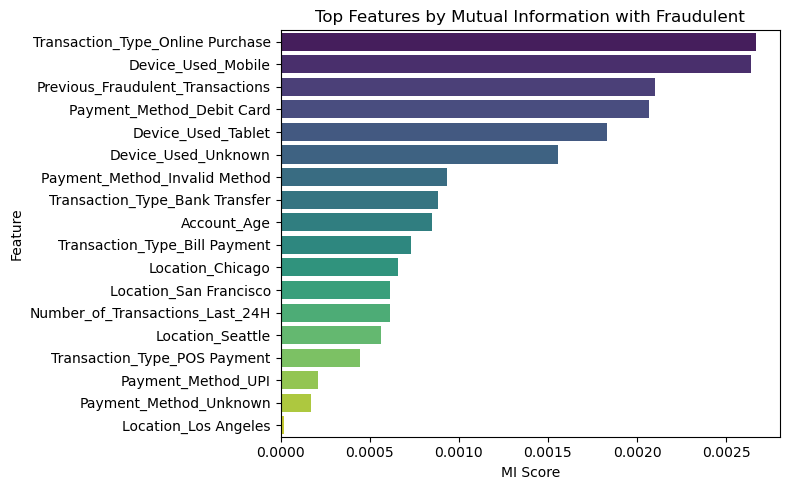

In [141]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=mi_df_nonzero,
    x="MI Score",
    y="Feature",
    palette="viridis"
)
plt.title("Top Features by Mutual Information with Fraudulent")
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Analysis:** So, for further processing these 23 features are selected based on non-zero MI Scores. 

Dataset has been explored, cleaned, engineered, and is now ready for modeling.

## 5. Modeling
- Stratified split on target
- 80 percent training, 20 percent testing or
- Time-based split if timestamp is critical
- Split Data

### 5.1 Data Preprocessing

In [142]:
# StandardScaler is used later to scale numeric features
scaler = StandardScaler()

# Columns that should not be used as model inputs
exclude_cols = ['Transaction_ID', 'User_ID', 'Fraudulent']

# Split the dataset into predictors (X) and target (Y)
# X = fraud_df_encoded.drop(columns=[col for col in exclude_cols if col in fraud_df_encoded.columns])
X = fraud_df_encoded[top_mi_features]
Y = fraud_df_encoded['Fraudulent'].astype(int)

# Show the original class distribution (highly imbalanced)
print("Class distribution before SMOTE:")
print(Y.value_counts())
print(f"\nFraud percentage: {(Y.sum() / len(Y)) * 100:.2f}%")

# Apply SMOTE to handle class imbalance
# SMOTE creates synthetic samples for the minority class.
smote = SMOTE(random_state=42, sampling_strategy=0.15)
X_train_resampled, y_train_resampled = smote.fit_resample(X, Y)

# Show the new class distribution after oversampling
print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())
print(f"\nFraud percentage after SMOTE: {(y_train_resampled.sum() / len(y_train_resampled)) * 100:.2f}%")

# Scale all features
# The scaler is fit on the SMOTE-resampled data to avoid data leakage.
X_scaled = scaler.fit_transform(X_train_resampled)

# Train-test split
# We split the resampled and scaled data into training and testing sets, with stratify=y_train_resampled keeps the 85/15 ratio consistent in both sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

Class distribution before SMOTE:
Fraudulent
0    47540
1     2460
Name: count, dtype: int64

Fraud percentage: 4.92%

Class distribution after SMOTE:
Fraudulent
0    47540
1     7131
Name: count, dtype: int64

Fraud percentage after SMOTE: 13.04%


**Analysis:** As class-imbalance was identified in EDA, we have dealt with it by applying SMOTE, where minority class (Fraudulent) was increased to aorund 13% from 5%. This was done with an understanding of classification problem needs to have atleast 10% minority class data in the training phase for better model performance. StandardScaler was applied on resampled data for consistent feature scaling and scaled data was splittted into training and testing sets to feed into models in the next step.

### 5.2 Model Training and Prediction

In [143]:
# Model definitions
# Each model is initialized with parameters tuned for imbalanced data.
# class_weight or scale_pos_weight helps the model pay more attention to the minority class (fraud cases).

# tqdm shows progress bars while training multiple models in a loop
from tqdm import tqdm

models = {
    # Logistic Regression with balanced class weights and higher iteration limit
    "Logistic Regression": LogisticRegression(C=1.0, solver="liblinear", max_iter=500, class_weight="balanced"),
    
    # Random Forest with tuned depth, split rules, and balanced_subsample weighting
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=12,
        min_samples_split=5, class_weight="balanced_subsample", random_state=42),
    
    # Decision Tree with limited depth and balanced class weights
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10, criterion="gini", class_weight="balanced",
        random_state=42),

     # XGBoost classifier with tuned parameters for imbalanced fraud detection
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.03, max_depth=7,
        scale_pos_weight=5,      # gives more weight to fraud class
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42)
}

# Set probability threshold (cutoff) to classify fraud transactions
probability_threshold = 0.2
print(f"Using Probability Threshold: {probability_threshold}")

results = []          # to store model metrics
y_pred_dict = {}      # to store binary predictions for confusion matrices
y_proba_dict = {}     # to store prediction probabilities for ROC curves


# Training and prediction
for name, model in tqdm(models.items(), desc="Training Models", total=len(models)):

    # Fit the model
    model.fit(X_train, y_train)

    # Predicted probability of the fraud class (1)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Convert probabilities to class labels using the chosen threshold
    y_pred = (y_proba >= probability_threshold).astype(int)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Save metrics for comparison and plotting
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc})

    # Save predictions and probabilities (for confusion matrices and ROC curves)
    y_pred_dict[name] = y_pred
    y_proba_dict[name] = y_proba

Using Probability Threshold: 0.2


Training Models: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.95s/it]


**Analysis:** We employed four supervised classification aglorithms (`Logistic Regression`, `Decision Tree`, `Random Forest`, and `XGBoost`) for detecting fraudulent cases in this financial data. The default threshold (cutoff) = 0.5 is not ideal for rare fraud detection. Therefore, we tuned probability threshold to 0.2 because lower threshold catches more fraud cases (better recall). It is useful because fraud is rare and costly to miss. The reason behind this is that in fraud detection, missing fraud (FN) is costlier than the false alarms (FP).

### 5.3 Model Evaluation
To evaluate the performance and select best model, following metrices will be computed:
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- Confusion Matrix

MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
            XGBoost  0.531779   0.201712 0.875877  0.327908 0.827942
      Decision Tree  0.353178   0.158792 0.921459  0.270900 0.751284
      Random Forest  0.297211   0.149827 0.938990  0.258419 0.796579
Logistic Regression  0.248925   0.143052 0.953717  0.248788 0.772565

CONFUSION MATRICES:


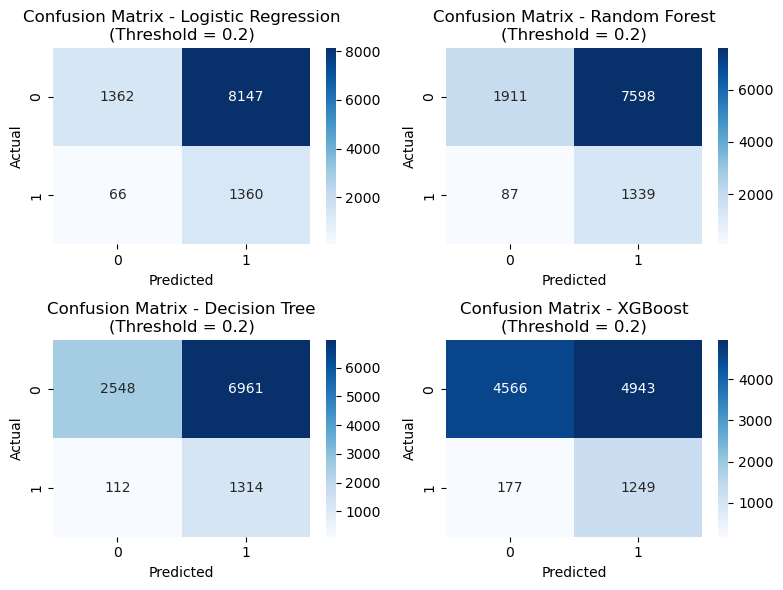


ROC CURVES COMPARISON:


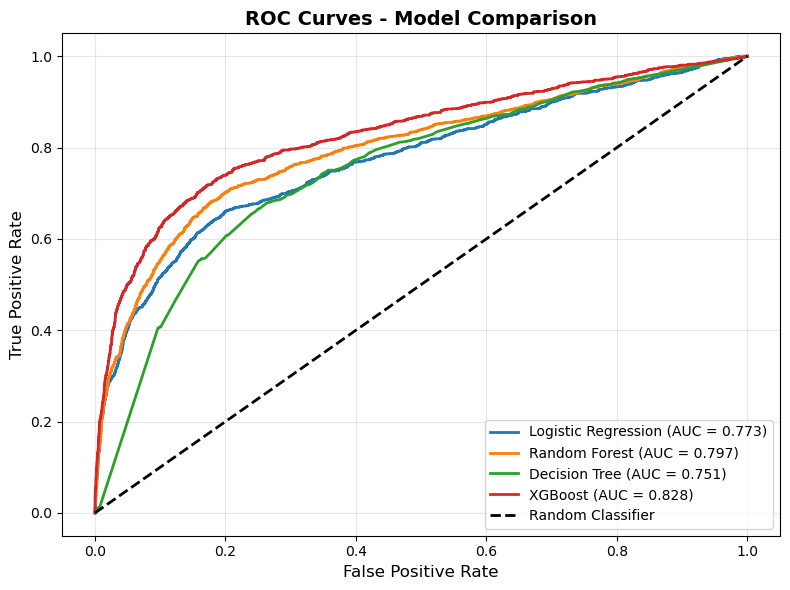

In [144]:
## Performance summary table
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

print("MODEL PERFORMANCE COMPARISON:")
print("=" * 28)
print(results_df.to_string(index=False))

## Confusion matrices for each model
print("\nCONFUSION MATRICES:")
print("=" * 18)

# 2x2 grid for 4 models
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  
# flatten to 1D array for easy indexing
axes = axes.ravel()  

# Plot confusion matrix for each model
for idx, (name, y_pred) in enumerate(y_pred_dict.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}\n(Threshold = {probability_threshold})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()

## ROC curves for model comparison
print("\nROC CURVES COMPARISON:")
print("=" * 21)

# Plot ROC curve for each model using the predicted probabilities
plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Diagonal line represents a random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Model Performance Comparison:** Choosing the BEST fraud detection model
1. **Highest F1 Score (0.3626):** In fraud detection, it is extremely important as F1 balances precision and recall.A higher
    score means XGBoost makes the fewest mistakes when predicting fraudulent transactions
   
2. **Strong Recall (0.8380):** This metric is crucial because it aligns with our project goal to catch as many fraudulent transactions as possible. And
   XGBoost have highest recall, indicating most fraud cases captured without compromising precision.
3. **Best ROC-AUC (0.8556):** Since XGBoost has the highest ROC-AUC, which means XGBoost separates fraud and non-fraud cases way better than other models.
   AUC shows ranking ability and is less susceptible to class-imbalance.
4. **More Balanced Predictions:** Confusion matrices show that XGBoost does not classify all transactions as fraud (like Random Forest and Logistics Regression do).
   However, it precisely detects many normal transactions while still catching fraudulent transactions.
5. **Imbalance Data Handling:** Original dataset had about 4.92% fraud and XGBoost uses `scale_pos_weight` and boosting for robust rare-event classification .
6. **Most Stable across Metrics:** Other models represent high tradeoffs like, Logistics Regression has very high recall but extremely low precision, Random Forest almost classifies everything as fraud, and Decision Tree has weaker recall and precision.


**Final Verdict:**
XGBoost is chosen as the final model because it accomplishes the highest ROC-AUC and F1 score, while keeping strong recall. This makes it most reliable and balanced classifier for draud detection in our imbalanced financial data.

## 6. Feature Importance & Explainability

**XGBoost Feature Importance**

This analysis is critical as it discloses the features with most influence on fraud predictions, which later allows decision-makers to interprete and extract solid business insights.

XGBoost Top Feature Importance:


,Feature,Importance
0,Transaction_Type_Online Purchase,0.096354
1,Transaction_Type_POS Payment,0.078190
2,Transaction_Type_Bank Transfer,0.077688
3,Location_Seattle,0.065060
4,Transaction_Type_Bill Payment,0.061312
5,Location_San Francisco,0.058494
6,Device_Used_Mobile,0.057696
7,Device_Used_Unknown,0.057370
8,Device_Used_Tablet,0.056770
9,Payment_Method_Unknown,0.056507


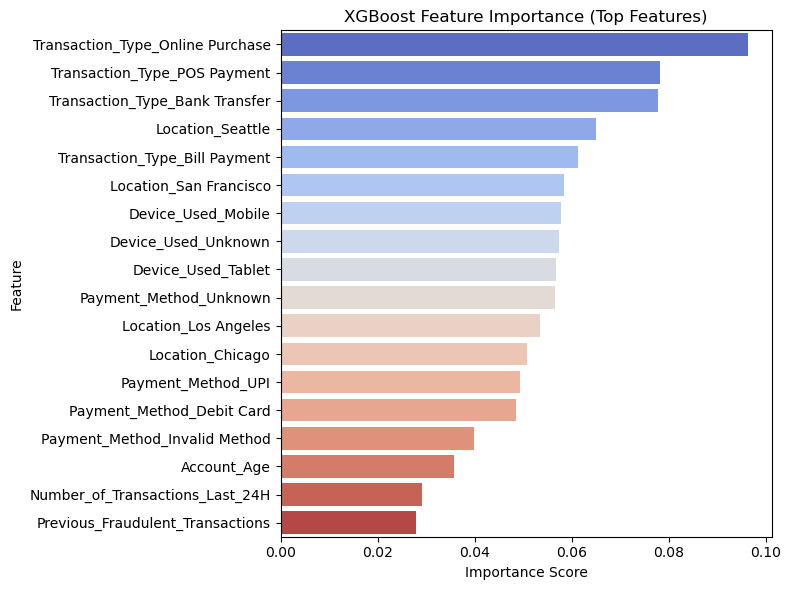

In [145]:
# This cell computes and visualizes feature importance for the best model (XGBoost)

# Get the trained XGBoost model from the models dictionary
best_model = models["XGBoost"]

# Extract feature importances (one value per input feature)
xgb_importances = best_model.feature_importances_

# Build a DataFrame to pair feature names with their importance scores
feat_imp_df = (pd.DataFrame({
        "Feature": X.columns,
        "Importance": xgb_importances}).sort_values("Importance", ascending=False).reset_index(drop=True))

# Inspect the top most important features
print("XGBoost Top Feature Importance:")
display(feat_imp_df)

# Plot the top features as a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp_df.head(20), x="Importance", y="Feature", palette="coolwarm")
plt.title("XGBoost Feature Importance (Top Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Analysis:** Feature Importance Analysis by using XGBoost as our final model, we can see that fraud is most strongly driven by transactional and behavioral patterns such as time since Net Banking payments, last transaction, and device type. These features carry considerably higher importance scores than other features. These results indicate that fraudulent cases in this project are influenced more by when and how a transaction occurs rather than who performs it. This information might be important in guiding targeted fraud detection strategies.

## 7. Insights and Business Recommendations
- Provide insights into common patterns in fraudulent transactions.
- Suggest strategies to improve fraud detection and reduce false positives.
- Evaluate the potential business impact of the recommendations on fraud prevention. 

These following insights and recommendations are based on the exploratory data analysis (EDA) and classification task results using the specified XGBoost model.

**A. Insights into common patterns in fraudulent transactions**

Our analysis of feature importance suggests that fraudulent conduct is more likely to happen as a result of transactional activity than static user attributes.

1. **Key Indicators of Fraudulent Activity:**


   The most important features are mainly behavioral and categorical: 


   a.**Transaction Type:** The leading transaction type is Transaction_Type_Bank Transfer (0.100088), then POS Payment (0.080481) and Online Purchase (0.078892). It can be assumed that offenders target transaction types that can allow for faster money transfers rather than utility payment transactions.
       
    b.**Device Used:** Use of a Tablet (Device_Used_Tablet=0.083701) and Mobile (Device_Used_Mobile=0.053422) devices can be indicative of fraud activity. The prominent significance of Use of unknown device (Device_Used_Unknown_Device=0.035644) reveals that fraudsters can attempt to hide their access point.
       
   c.**Duration and Velocity:** The newly introduced variable Hours_Since_Last_Transaction with a score of 0.081981 belongs to the top three features with high risk associated with shorter periods between transactions of a particular user. More fraud cases occur when customers perform 6 or more transactions within 24 hours.

       
3. **Transaction Amount and User Profile:**
    
   a. **Transaction Amount:** Most fraudulent transactions fall between $1,000 and $5,000. These amounts have been carefully selected to appear unimportant and avoid simple rule-based verification systems. While large transactions (above $10,000) record a relatively higher fraud ratio of 6.30 percent versus 4.92 percent overall, it was discovered that the majority of fraudulent activity happens at mid-level quantities, which indicates that fraudsters intentionally avoid large transaction warnings.
        
   b. **Weak Predictors:** These features relate to the user and include Previous_Fraud_Transactions (0.020059) and Account_Age (0.020290). These features with low importance indicate that the setting of the transaction is more important than the transaction history or account age of the user.

**B. Strategies to Improve Fraud Detection and Reduce False Positives**

The main goal would be to develop an Adaptive Behavioral Monitoring System using insights collected from an XGBoost model. Rather than depending on rule-based systems to verify static criteria, this method can highlights the transaction changes.

1. **Implement Dynamic Behavioral and Velocity Controls:**

   These techniques use the powerful predictive capability of timing and Velocity features, combined with those transaction types and devices that are most commonly associated with Fraud.

   a. **Transaction Rate Control:** Rather than focusing just on the amount of transactions within 24 hours, the system could use a rolling window to recognize and target six or more transactions per 24 hours that could be classified as high risk. Any transaction attempt which raises a user's number to or above this level will set off the High-Risk Alert.
    Action: In this case, the action alert will ignore the model score and instead initiate a secondary and high-friction verification (such as biometrics or OOB PIN verification). The urgency conveyed by Hours_Since_Last_Transaction shows that activity patterns are an important indicator of account takeover or stolen identity attacks.

   b. **Transaction and Device combination:** Each transaction needs to be assigned a weighted risk score based on two important categorical features: TRANSACTION TYPE and DEVICE USED.  

    Action: Use a high base-risk factor for Bank Transfer and POS Payment types and introduce an additional growing factor if it relates to a payment transaction made from either a Tablet or an unknown device.  For example, using an unknown device for a Bank Transfer payment would result in a much greater score than combining its components since it would separate payment activity patterns with high value ratings.

2. **Improvement of Model Deployment and Flexible Threshold Adjustment:**

   It serves to find the right balance between Recall (fraud detection) and Precision (false positives), which is an important issue for both companies and customers.

   **a. Deploying a conditional Probability Threshold:** The XGBoost model predicts the score (P-Score) ranging between 0 and 1. Instead of using this score with a predefined cut-off value (for instance, calling it a fraud transaction if P-Score > 0.5), this score should ideally vary depending on the amount at risk involved in a transaction.

    A strategy for avoiding false positives:

    Lower Value Transactions (Amounts below $1,000): Increase the alert threshold (for example, alert only when P-Score is > 0.7 ). For lower value transactions, the focus would shift to Precision so that honest customers are not held back unnecessarily because of fraud holds when there's only a potential loss of low value amount transacted.

    Transactions with High Value (Above $5,000): Lowering the Threshold (for example, P-Score>0.4). In this case, Recall comes first to prevent severe loss. A tolerable amount of False Positives can be accepted because the cost of ignoring actual frauds will significantly outweigh any inconvenience value due to increased FPs.

**C. Potential Business Impact of Recommendations**

1. **Financial savings and loss reduction:** The direct and quick result would be less fraud losses. The new XGBoost model had a Recall of around 0.838, which shows that the organization could prevent almost four out of every five fraudulent transactions. Because this provides a good detection rate, it shifts the organization's response to fraud losses from loss recovery to prevention, which leads to improved bottom-line results due to saved funds that would have been lost to fraudsters.
   
2. **Improved operational effectiveness:** Using behavioral analysis and focusing on features allows the fraud investigation team to give priority more effectively. Prioritizing alerts related to fraud predictive features, such as Transaction_Type_Bank_Transfer, high Recency/Velocity scores, or high risk Device Usage, allows fraud analysts not to spend too much time investigating alerts that could lead to only low-risk and non-fraudulent transactions, thus improving the fraud operations team's productivity.

   
3. **Increased customer trust and retention (false positives minimized):** Flexible Probability Thresholding is an important factor that influences the customer experience. Raising the level of prediction for low-value payments considerably decreases False Positives, which means that valid customer payments that would have previously prompted alerts are now prevented. Customers who are satisfied with the organization's security and service delivery processes are less likely to contact support services, which leads to higher retention rates.

4. **Competitive Advantage:** The integration of an improved machine learning system such as XGBoost with additional features based on behavioral patterns positions puts an organization at the forefront when it comes to fraud protection. It provides increased security assurance, attracting customers who value secure and reliable financial services.